# 01 - Framework

## Set up

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy as sp
import pandas as pd

import warnings
import tqdm

import pandas_datareader.data as web
import datetime as dt

import statsmodels.api as sm
import linearmodels as lm
import arch as am

import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')
import src

sys.path.append('../../kungfu/')
import kungfu as kf

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set()
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

In [6]:
#from src.models import NormalModel
#from src.hmm import HMM
import src

## Load data

In [7]:
df_predictors = pd.read_pickle('../data/external/df_predictors.pkl')
s_dp = df_predictors.dp.asfreq('M')
s_ret = df_predictors['Index'].pct_change().asfreq('M')

In [8]:
s_daily = pd.read_pickle('../data/external/market_daily.pkl').set_obstype('return')
s_monthly = pd.read_pickle('../data/external/market_monthly.pkl').set_obstype('return')

In [9]:
series = s_dp.dropna()

In [10]:
series = s_ret.dropna()

In [12]:
series = s_daily

In [13]:
series = s_monthly

## Compare densities

In [11]:
from sklearn.mixture import GaussianMixture
#from src.dists import GaussianMixtureDistribution

In [14]:
def fit_gaussian_mixture_distribution(data, K=1):
    
    '''
    MOVE
    '''
    
    # Gaussian mixture model
    gmm = GaussianMixture(n_components=K).fit(data.values.reshape(-1,1))
    
    # Obtain mixture distribution
    mix = src.MixtureDistribution([])
    for (m,s,p) in zip(gmm.means_.flatten(),gmm.covariances_.flatten()**0.5,gmm.weights_):
        mix.add_component(distribution=src.NormalDistribution(mu=m, sigma=s), weight=p)
        
    return mix

def fit_kernel_density_distrbution(data, method='scott'):
    
    '''
    
    '''
    
    # equal weights
    w = 1/data.count()
    
    # scale parameter
    if method == 'scott':
        s = 3.5*data.std()/(data.count()**(1/3))
    if method == 'silverman':
        s = ((4*data.std()**5)/(3*data.count()))**(1/5)
    
    # create mixture
    kde = src.MixtureDistribution(components=[(src.NormalDistribution(mu=m, sigma=s), w) for m in data])
#     kde = GaussianMixtureDistribution([(m,s,w) for m in data])
    return kde

def fit_normal_distribution(data):
    normal = src.NormalDistribution(mu=data.mean(), sigma=data.std())
#     normal = sp.stats.norm(data.mean(),data.std())
    return normal

In [29]:
kde = fit_kernel_density_distrbution(series, method='silverman')
mix2 = fit_gaussian_mixture_distribution(series, K=2)
mix3 = fit_gaussian_mixture_distribution(series, K=3)
mix4 = fit_gaussian_mixture_distribution(series, K=4)
mix5 = fit_gaussian_mixture_distribution(series, K=5)
mix8 = fit_gaussian_mixture_distribution(series, K=8)
mix16 = fit_gaussian_mixture_distribution(series, K=16)
mix32 = fit_gaussian_mixture_distribution(series, K=32)
mix64 = fit_gaussian_mixture_distribution(series, K=64)
normal = fit_normal_distribution(series)
#normal2 = fit_gaussian_mixture_distribution(series, K=1)

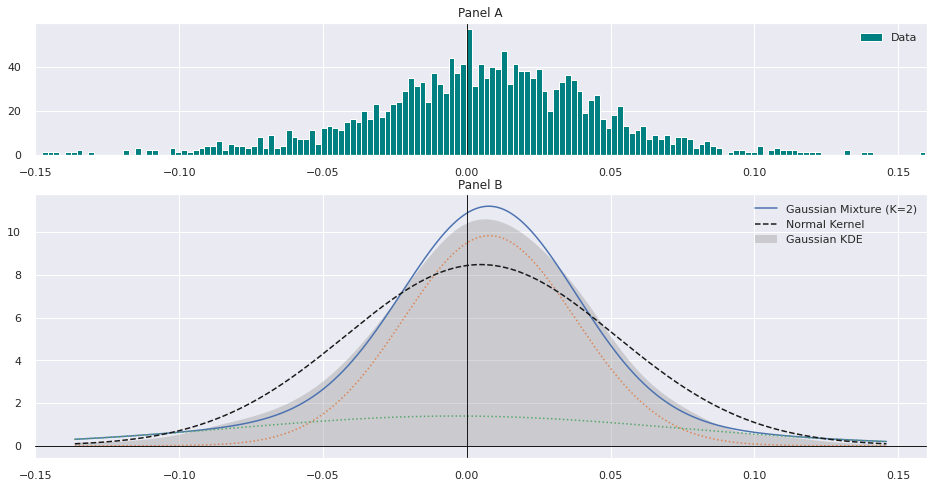

In [31]:
# plot
from src.plots import plot_mixture_components, plot_kernel_density, plot_pdf

#mix = hmm.get_mixture_distribution(state='steady_state')

fig, axes = plt.subplots(2, 1, figsize=[16,8], gridspec_kw={'height_ratios': [1, 2]})

ax = axes[1]
plot_pdf(mix2, ax=ax, label='Gaussian Mixture (K=2)')
plot_mixture_components(mix2, ax=ax)
plot_kernel_density(series, ax=ax, label='Gaussian KDE', color='grey')
plot_pdf(normal, ax=ax, linestyle='--', color='k', label='Normal Kernel')
ax.axhline(0, color='k', linewidth=1)
ax.axvline(0, color='k', linewidth=1)
ax.set_title('Panel B')
ax.legend()

lim = ax.get_xlim()
ax = axes[0]
ax.set_xlim(lim)
ax.hist(series,bins=series.count()//5, color='teal', label='Data')
ax.axvline(0, color='k', linewidth=1)
ax.set_title('Panel A')
ax.legend()

fig.savefig('../latex/figures/distribution_comparison.pdf', format='pdf', dpi=200, bbox_inches='tight')

plt.show()

In [32]:
def kolmogorov_smirnov_test(data, distribution):
    test_statistic = sp.stats.kstest(data, distribution.cdf)[0]
    return test_statistic

def kuipers_test(data, distribution):
    test_statistic = sp.stats.kstest(data, distribution.cdf, alternative='less')[0]\
                        + sp.stats.kstest(data, distribution.cdf, alternative='greater')[0]
    return test_statistic

def distribution_log_likelihood(data, distribution):
    log_likelihood = np.log(distribution.pdf(data)).sum()
    return log_likelihood

In [69]:
def data_stats(data):
    values = [data.mean(),
              data.std(),
              data.skew(),
              data.kurt()-3,
              np.nan,
              np.nan,
             np.nan]
    return values

def comparison_stats(data, distribution):
    values = [distribution.mean(),
              distribution.std(),
              distribution.skew(),
              distribution.exkurt(),
              kolmogorov_smirnov_test(data, distribution),
              kuipers_test(data, distribution),
              distribution_log_likelihood(data, distribution)]
    return values

In [70]:
comparison_table = kf.FinancialDataFrame(columns=['mean','std','skew','exkurt','Kolmogorov-Smirnov','Kuiper\'s test','log-likelihood'])

comparison_table.loc['Data'] = data_stats(series)
comparison_table.loc['Gaussian KDE'] = comparison_stats(series, kde)
comparison_table.loc['Normal Distribution (K=1)'] = comparison_stats(series, normal)
comparison_table.loc['Gaussian Mixture (K=2)'] = comparison_stats(series, mix2)
comparison_table.loc['Gaussian Mixture (K=3)'] = comparison_stats(series, mix3)
comparison_table.loc['Gaussian Mixture (K=4)'] = comparison_stats(series, mix4)
comparison_table.loc['Gaussian Mixture (K=5)'] = comparison_stats(series, mix5)
comparison_table.loc['Gaussian Mixture (K=8)'] = comparison_stats(series, mix8)
comparison_table.loc['Gaussian Mixture (K=16)'] = comparison_stats(series, mix16)
comparison_table.loc['Gaussian Mixture (K=32)'] = comparison_stats(series, mix32)
comparison_table.loc['Gaussian Mixture (K=64)'] = comparison_stats(series, mix64)

comparison_table = comparison_table.replace(np.nan,'')\
                                   .replace(0,'')

#comparison_table.export_to_latex(path='../latex/tables/', filename='distribution_comparison')

comparison_table

,mean,std,skew,exkurt,Kolmogorov-Smirnov,Kuiper's test,log-likelihood
Data,0.0048,0.0470,0.2961,7.7967,,,
Gaussian KDE,0.0048,0.0483,0.2726,6.6491,0.0175,0.0348,3136.9022
Normal Distribution (K=1),0.0048,0.0470,,0.0000,0.0663,0.1266,2927.4047
Gaussian Mixture (K=2),0.0048,0.0470,-0.3223,-0.0701,0.0126,0.0246,3090.0651
Gaussian Mixture (K=3),0.0048,0.0470,-0.4222,2.8108,0.0112,0.0198,3116.2190
Gaussian Mixture (K=4),0.0048,0.0470,-0.1162,8.7958,0.0158,0.0304,3118.1303
Gaussian Mixture (K=5),0.0048,0.0470,0.1528,10.8833,0.0143,0.0263,3117.6657
Gaussian Mixture (K=8),0.0048,0.0470,0.3071,7.8817,0.0126,0.0208,3123.0568
Gaussian Mixture (K=16),0.0048,0.0470,0.2940,7.7018,0.0080,0.0147,3135.1753
Gaussian Mixture (K=32),0.0048,0.0470,0.2957,7.7532,0.0073,0.0140,3171.8267


## Forecast Plots

#### Set up model

In [98]:
emission_models = (src.NormalModel(mu=0.1, sigma=0.2), src.NormalModel(mu=-0.2, sigma=0.3))
transition_matrix = np.matrix([[0.8, 0.2],
                               [0.3, 0.7]])
state_vector = [0.7, 0.3]
hmm = src.HiddenMarkovModel(emission_models=emission_models, transition_matrix=transition_matrix, state_vector=state_vector)

In [88]:
hmm.steady_state()

array([0.6, 0.4])

In [73]:
hmm.fit(series)

../src/hmm.py:352: UserWarning: Transition matrix rounded to 6 decimal places
  warnings.warn('Transition matrix rounded to 6 decimal places')
../src/hmm.py:361: UserWarning: State vector rounded to 8 decimal places
  warnings.warn('State vector rounded to 8 decimal places')


In [94]:
hmm.transition_matrix

array([[0.8, 0.2],
       [0.3, 0.7]])

In [95]:
hmm.component_means(), hmm.component_stds()

([0.1, -0.2], [0.1, 0.3])

In [96]:
hmm.state_vector

array([[0.7, 0.3]])

<AxesSubplot:>

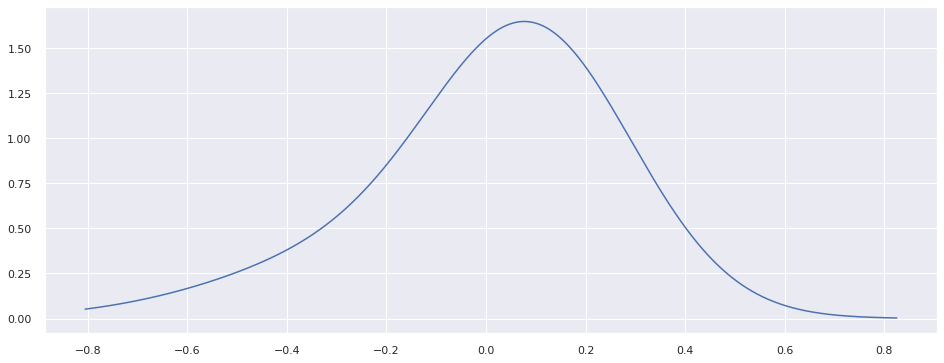

In [99]:
plot_pdf(hmm.iterate(0).mixture_distribution)

In [117]:
state_names = ['SS','S0','S1']
H = 8

Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode
Substituting symbol E from STIXNonUnicode


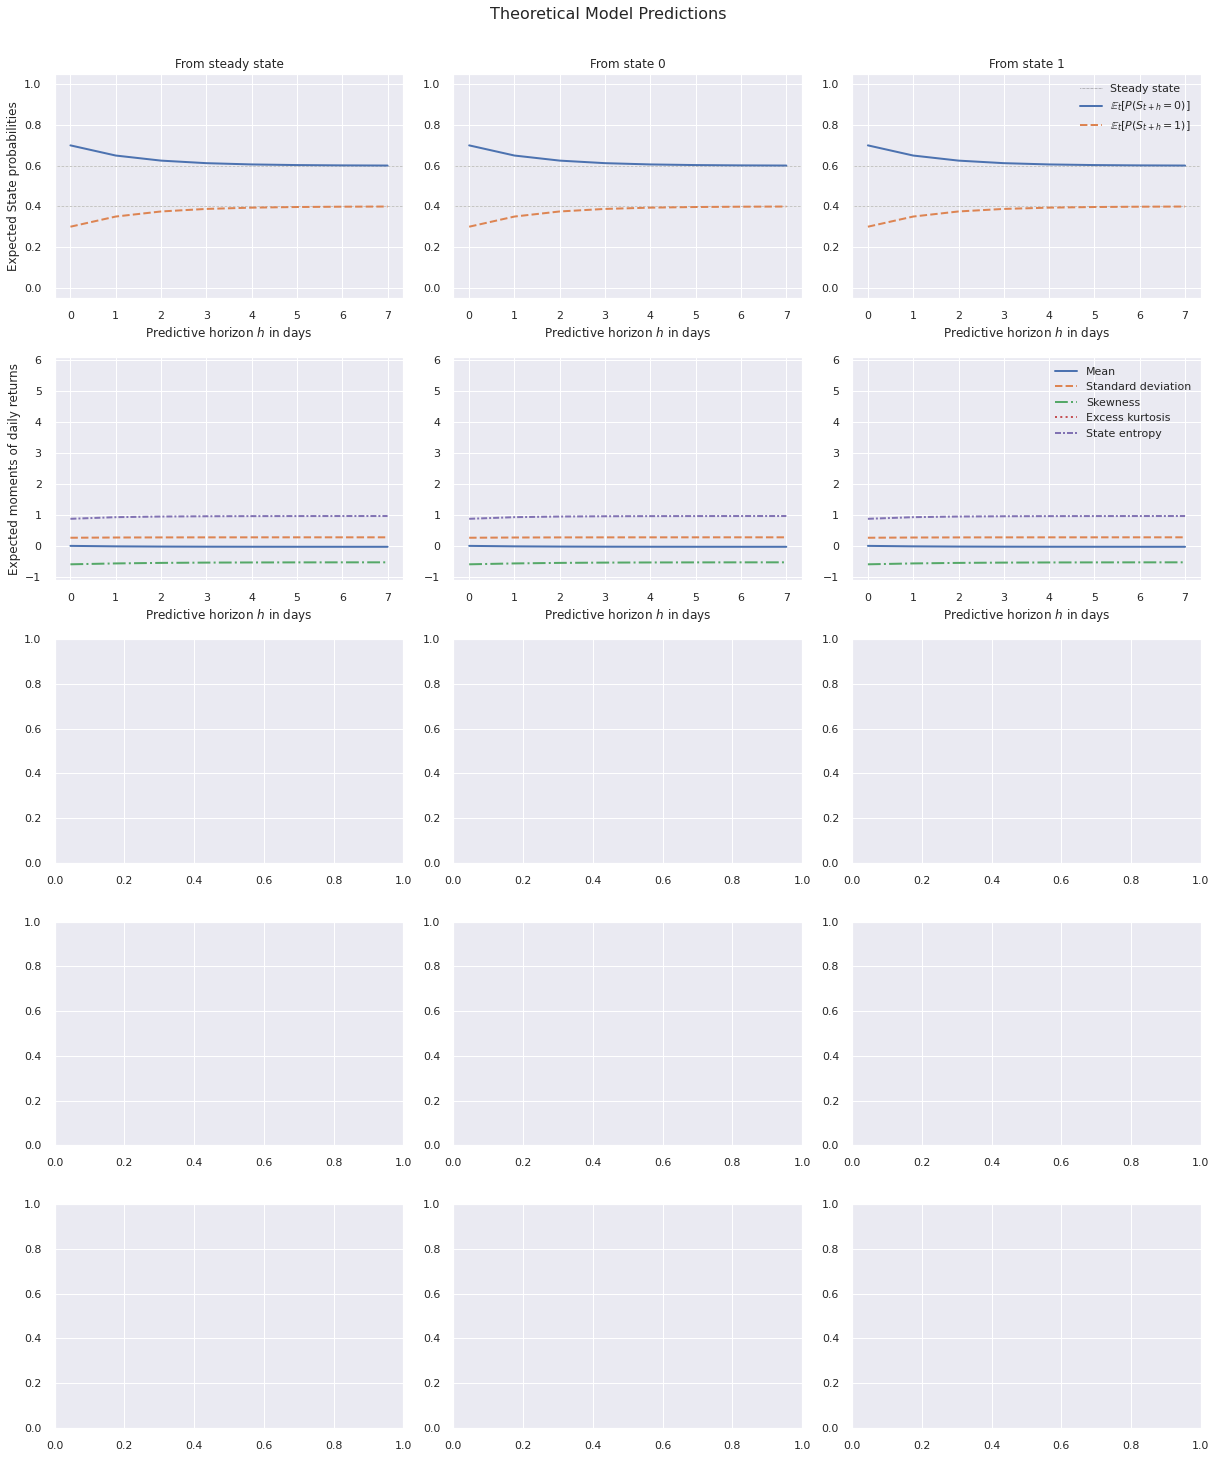

In [131]:
fig, axes = plt.subplots(5, 3, figsize=[17,20])
colormap = plt.cm.get_cmap('coolwarm')

i = 0
for iState in state_names:
    axes[0,i].set_ylim([-0.05,1.05])
    axes[0,i].axhline(hmm.steady_state()[0], color='k', linewidth=0.5, linestyle=':', label='Steady state')
    axes[0,i].axhline(hmm.steady_state()[1], color='k', linewidth=0.5, linestyle=':')
    axes[0,i].plot([hmm.iterate(h).state_vector.squeeze()[0] for h in range(H)], linewidth=2, linestyle='-', label='$\mathbb{E}_t[P(S_{t+h}=0)]$')
    axes[0,i].plot([hmm.iterate(h).state_vector.squeeze()[1] for h in range(H)], linewidth=2, linestyle='--', label='$\mathbb{E}_t[P(S_{t+h}=1)]$')
    axes[0,i].set_xlabel('Predictive horizon $h$ in days')
    
#     axes[1,i].set_ylim([-1.1,6.1])
    axes[1,i].plot([hmm.iterate(h).mean() for h in range(H)], linewidth=2, linestyle='-', label='Mean')
    axes[1,i].plot([hmm.iterate(h).std() for h in range(H)], linewidth=2, linestyle='--', label='Standard deviation')
    axes[1,i].plot([hmm.iterate(h).skew() for h in range(H)], linewidth=2, linestyle='-.', label='Skewness')
    axes[1,i].plot([hmm.iterate(h).exkurt() for h in range(H)], linewidth=2, linestyle=':', label='Excess kurtosis')
    axes[1,i].plot([hmm.iterate(h).entropy() for h in range(H)], linewidth=2, linestyle=(0, (3, 1, 1, 1)), label='State entropy')
    axes[1,i].set_xlabel('Predictive horizon $h$ in days')
    
    axes[2,i].set_ylim([-0.2,1.05])
    axes[2,i].plot([hmm.iterate(h).entropy() for h in range(H)], linewidth=2, linestyle='-', label='Mean')
#     axes[2,i].plot(df_calc[(iState,'cv')]**0.5, linewidth=2, linestyle='--', label='Standard deviation')
#     axes[2,i].plot(df_calc[(iState,'cs')], linewidth=2, linestyle='-.', label='Skewness')
#     axes[2,i].plot(df_calc[(iState,'ck')], linewidth=2, linestyle=':', label='Excess Kurtosis')
#     axes[2,i].set_xlabel('Accumulation Period $H$ in days')
    
#     h = 0
#     for iHorizon in [0,1,5,10,15,21,31,42,63,126,189,252]:
#         mixture = clas.MixtureDistribution([])
#         mixture.add_component((mus[0]-1,sigmas[0],df_calc[(iState,'p0')].loc[iHorizon]))
#         mixture.add_component((mus[1]-1,sigmas[1],df_calc[(iState,'p1')].loc[iHorizon]))
#         x = np.linspace(-0.06,0.06,201)
#         y = mixture.pdf(x)
#         axes[3,i].set_ylim([-2,70])
#         axes[3,i].plot(x, y, color=colormap(1/10*h), label='t+'+str(iHorizon), linewidth=2)
#         axes[3,i].set_xlabel('Daily return')
        
#         h +=1
        
    i += 1
    
axes[0,0].set_ylabel('Expected State probabilities')
axes[1,0].set_ylabel('Expected moments of daily returns')
# axes[2,0].set_ylabel('Expected moments of cumulative returns')
# axes[3,0].set_ylabel('Probability denstity of daily returns')

axes[0,0].set_title('From steady state')
axes[0,1].set_title('From state 0')
axes[0,2].set_title('From state 1')

axes[0,2].legend()
axes[1,2].legend()
# axes[2,2].legend()
# axes[3,2].legend()

fig.suptitle('Theoretical Model Predictions', y=1.01, fontsize=16)

fig.tight_layout()

plt.show()

#fig.savefig('theoreticalPredictionsPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

## LEGACY

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.stats as ss
import math
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import sklearn.mixture as mix
import datetime as dt

import mypack.plot as plot
import mypack.calc as calc
import mypack.clas as clas
import mypack.data as data

ModuleNotFoundError: No module named 'mypack'

In [3]:
pd.set_option('display.float_format', lambda x: '%.4f' % x) #sets decimals to be displayed

In [4]:
sns.set() # sets matplotlib style
sns.set(rc={'figure.figsize': (17, 6)})

In [5]:
%matplotlib inline

## Import data

In [7]:
df_market = pd.read_pickle('df_ts_estimates.pkl')

FileNotFoundError: [Errno 2] No such file or directory: 'df_ts_estimates.pkl'

In [7]:
df_daily = data.download_factor_data('D')['Mkt-RF']/100
#factors_monthly = data.download_factor_data('M')/100

## Shape of a Gaussian mixture

In [8]:
# inputs
mixture = clas.MixtureDistribution([])
mixture.add_component((-0.0015, 0.02, 0.3))
mixture.add_component((0.00075, 0.005, 0.7))
#mixture.add_component((-0.0013678325990907631, 0.020811215687394986, 0.19183567056256604))
#mixture.add_component((0.0006879740776781325, 0.0061089838682783365, 1-0.19183567056256604))

In [9]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture.components]
sigmas += [s for (m,s,p) in mixture.components]
ps += [p for (m,s,p) in mixture.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [10]:
# labels
(m,v,s,k) = mixture.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture.components,range(0,mixture.n_components))]

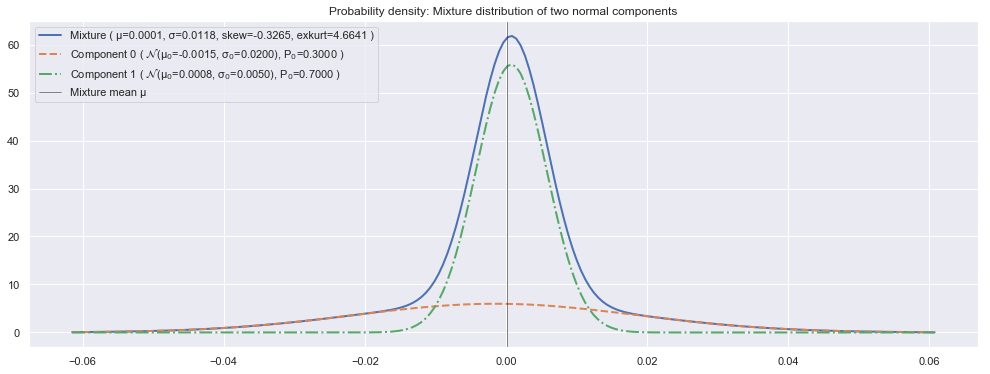

In [11]:
#plot
fig,ax = plt.subplots(1,1,figsize=[17,6])
#ax.axhline(0, color='k', linewidth=0.5)
ax.plot(x, y_mix, label=mix_label, linewidth=2)
ax.plot(x, ys[0], label=com_labels[0], linestyle='--', linewidth=2)
ax.plot(x, ys[1], label=com_labels[1], linestyle='-.', linewidth=2)
if len(ys) > 2:
    for iComp in range(2,len(ys)):
        ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Probability density: Mixture distribution of two normal components')
plt.show()

#fig.savefig('mixtureDistributionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Gaussian Mixture Model

In [12]:
n_components=2

In [13]:
# data
y = df_daily

# create kernel density estimate
kerneldensity  = sp.stats.gaussian_kde(y)
(m,v,s,k) = (y.mean(), y.var(), y.skew(), y.kurtosis())
kernel_label = 'Empirical kernel density ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'

In [14]:
# estimate mixture (from Gaussian mixture model)
mix_model = mix.GaussianMixture(n_components).fit(y.values.reshape(-1, 1))
mixture_gmm = clas.MixtureDistribution([])
for (m,s,p) in zip(mix_model.means_.flatten(),mix_model.covariances_.flatten()**0.5,mix_model.weights_):
    mixture_gmm.add_component((m,s,p))

(m,v,s,k) = mixture_gmm.mvsk()
mix_label = 'Gaussian mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_gmm.components,range(0,mixture_gmm.n_components))]

In [15]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture_gmm.components]
sigmas += [s for (m,s,p) in mixture_gmm.components]
ps += [p for (m,s,p) in mixture_gmm.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

y_normal = sp.stats.norm.pdf(x, y.mean(), y.var()**0.5)
normal_label = 'Normal distribution ( μ='+'{:0.4f}'.format(y.mean())+', σ='+'{:0.4f}'.format(y.var()**0.5)+' )'

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture_gmm.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [16]:
# labels
(m,v,s,k) = mixture_gmm.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_gmm.components,range(0,mixture_gmm.n_components))]

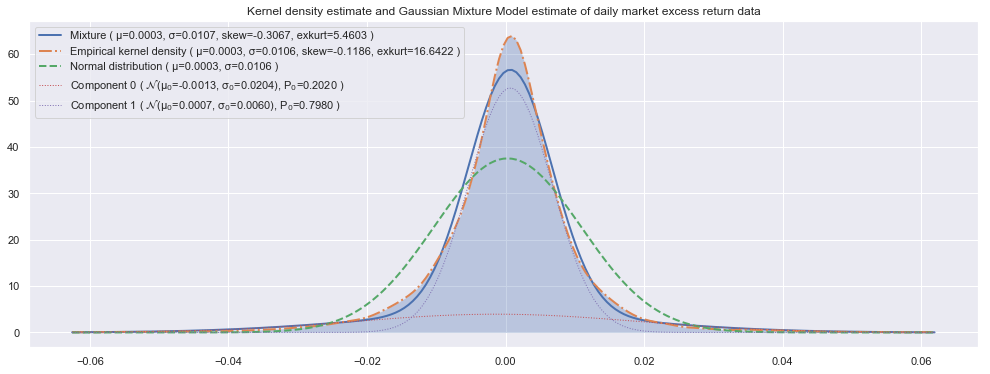

In [17]:
#plot
fig,ax = plt.subplots(1,1,figsize=[17,6])
#ax.axhline(0, color='k', linewidth=0.5)

ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
ax.plot(x, y_mix, label=mix_label, linewidth=2)
ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
ax.plot(x, y_normal, label=normal_label, linestyle='--', linewidth=2)

for iComp in range(0,len(ys)):
    ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
        
#ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Kernel density estimate and Gaussian Mixture Model estimate of daily market excess return data')
plt.show()

#fig.savefig('gaussianMixtureModelDistributionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


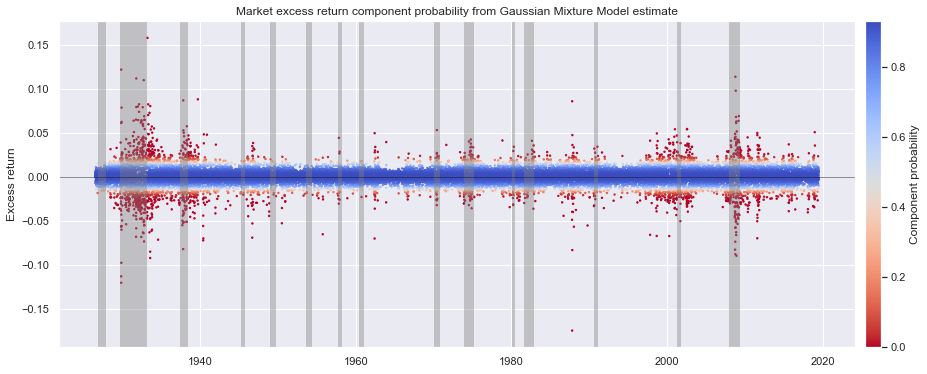

In [18]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = pd.DataFrame(mix_model.predict_proba(y.values.reshape(-1, 1)))[1]
size = 2#color*10
scat = ax.scatter(y.index, y, c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Excess return')
ax.set_title('Market excess return component probability from Gaussian Mixture Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01)
cbar.set_label('Component probability')
plt.show()

#fig.savefig('gaussianMixtureModelClassificationPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

## Trends in the data

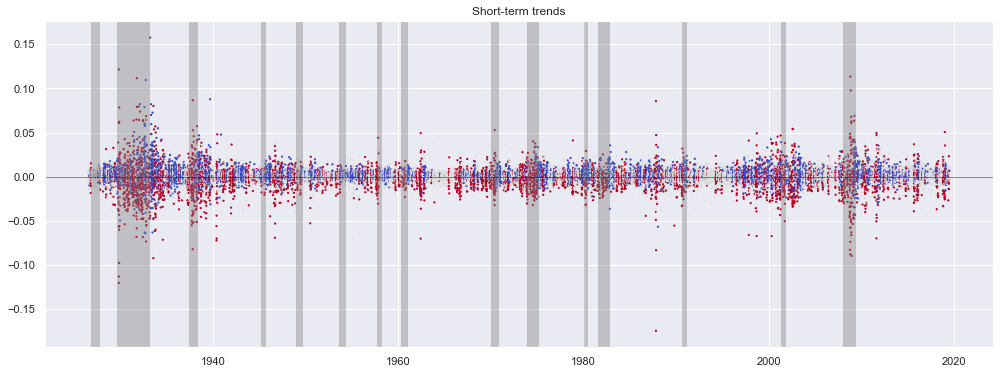

In [19]:
colormap = plt.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = ((y.rolling(22).mean()<y.rolling(22).mean().quantile(0.2)).astype(int)-(y.rolling(22).mean()>y.rolling(22).mean().quantile(0.8)))/2+0.5
ax.scatter(y.index, y, c=color, cmap=colormap, s=(color-0.5).abs()*2+0.5)
ax.set_title('Short-term trends')

plt.show()

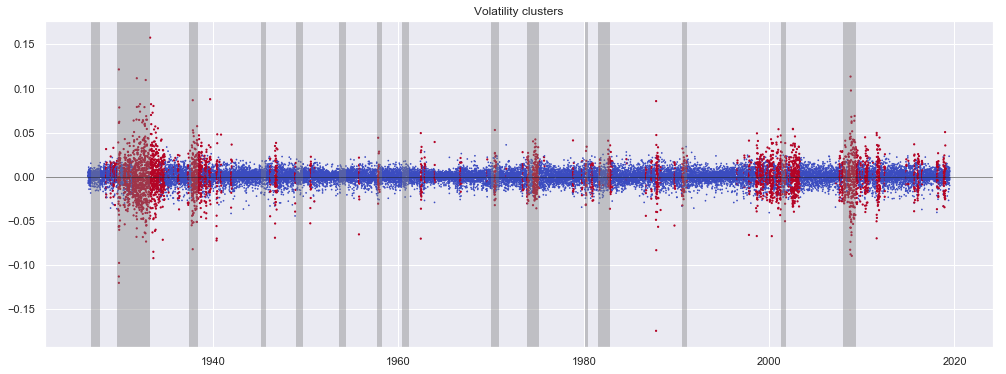

In [20]:
colormap = plt.cm.get_cmap('coolwarm')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
#ax.scatter(y.index, y, c=hmm_model.smoothed_marginal_probabilities[0], cmap=colormap, s=hmm_model.smoothed_marginal_probabilities[0]*2+0.2)
color = ((y**2).rolling(22).mean()>(y**2).rolling(22).mean().quantile(0.8))
size = color+0.5
ax.scatter(y.index, y, c=color, cmap=colormap, s=size)
ax.set_title('Volatility clusters')

plt.show()

## Hidden Markov Model

In [21]:
# data
y = df_daily

# create kernel density estimate
kerneldensity  = sp.stats.gaussian_kde(y)
(m,v,s,k) = (y.mean(), y.var(), y.skew(), y.kurtosis())
kernel_label = 'Empirical kernel density ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'

In [22]:
# estimate mixture (from Hidden Markov Model)
hmm_model = sm.tsa.MarkovRegression(y, k_regimes=2, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=[0.95,0.02,m,m,v*2,v/2], method='powell', disp=False)
(mu_0, mu_1) = hmm_model.params.values[2:4]
(sigma_0, sigma_1) = hmm_model.params.values[4:6]**0.5
(p0, p1) = hmm_model.smoothed_marginal_probabilities.mean().values
mixture_hmm = clas.MixtureDistribution([(mu_0, sigma_0, p0),(mu_1, sigma_1, p1)])

(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Gaussian mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [23]:
# calculations
mus,sigmas,ps = [],[],[]
mus += [m for (m,s,p) in mixture_hmm.components]
sigmas += [s for (m,s,p) in mixture_hmm.components]
ps += [p for (m,s,p) in mixture_hmm.components]

x = np.linspace(min(mus)-3*max(sigmas), max(mus)+3*max(sigmas), 201)

y_normal = sp.stats.norm.pdf(x, y.mean(), y.var()**0.5)
normal_label = 'Normal distribution ( μ='+'{:0.4f}'.format(y.mean())+', σ='+'{:0.4f}'.format(y.var()**0.5)+' )'

ys = []
y_mix = np.zeros(201)
for (m,s,p) in mixture_hmm.components:
    ys += [p*sp.stats.norm.pdf(x, m, s)]
    y_mix += p*sp.stats.norm.pdf(x, m, s)

In [24]:
# labels
(m,v,s,k) = mixture_hmm.mvsk()
mix_label = 'Mixture ( μ='+'{:0.4f}'.format(m)+', σ='+'{:0.4f}'.format(v**0.5)+', skew='+'{:0.4f}'.format(s)+', exkurt='+'{:0.4f}'.format(k)+' )'
com_labels = []
com_labels += ['Component '+str(i)+' ( $\mathcal{N}$(μ$_0$='+'{:0.4f}'.format(m)+', σ$_0$='+'{:0.4f}'.format(s)+'), P$_0$='+'{:0.4f}'.format(p)+' )' for (m,s,p),i in zip(mixture_hmm.components,range(0,mixture_hmm.n_components))]

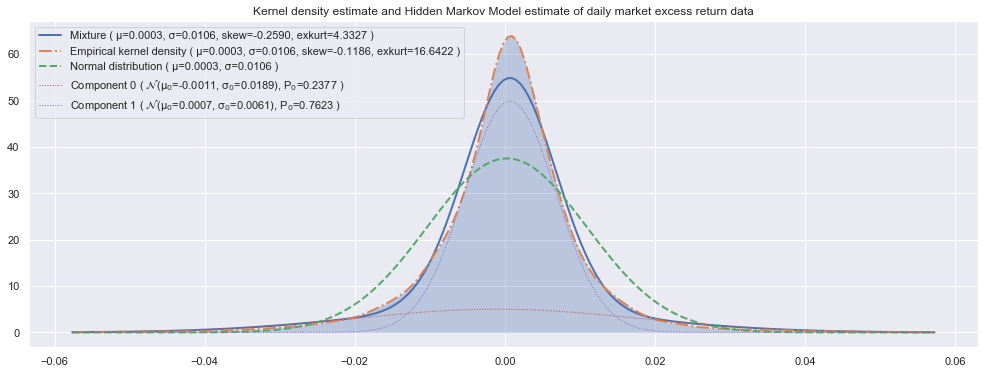

In [25]:
#plot
fig,ax = plt.subplots(1,1,figsize=[17,6])
#ax.axhline(0, color='k', linewidth=0.5)

ax.fill_between(x, kerneldensity(x), linewidth=0, alpha=0.3)#, color='#b6c4db'
ax.plot(x, y_mix, label=mix_label, linewidth=2)
ax.plot(x, kerneldensity(x), label=kernel_label, linewidth=2, linestyle='-.')
ax.plot(x, y_normal, label=normal_label, linestyle='--', linewidth=2)

for iComp in range(0,len(ys)):
    ax.plot(x, ys[iComp], label=com_labels[iComp], linestyle=':', linewidth=1)
        
#ax.axvline(m, color='k', linewidth=0.5, label='Mixture mean μ')
ax.legend(loc='upper left')
ax.set_title('Kernel density estimate and Hidden Markov Model estimate of daily market excess return data')
plt.show()

#fig.savefig('hiddenMarkovModelDistributionPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

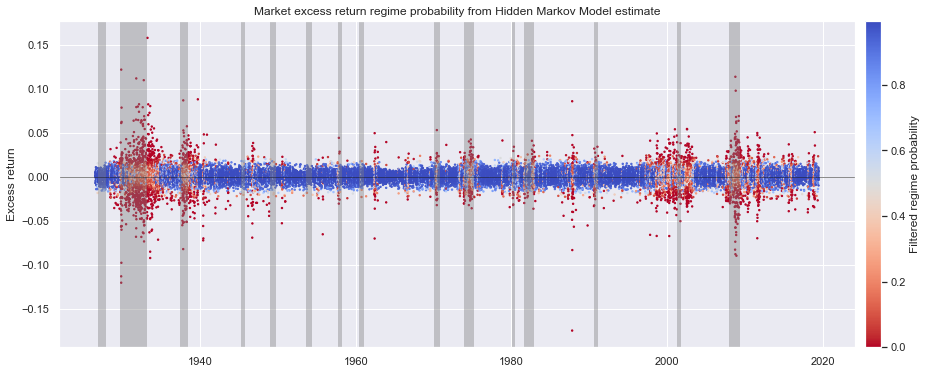

In [26]:
colormap = plt.cm.get_cmap('coolwarm_r')

fig, ax = plt.subplots(1,1,figsize=[17,6])
plot.add_recession_bars(ax, startdate=y.index[0])
ax.axhline(0, color='k', linewidth=0.5)
color = hmm_model.smoothed_marginal_probabilities[1]
color = hmm_model.filtered_marginal_probabilities[1]
size = 2#(color+5)
scat = ax.scatter(y.index, y, c=color, cmap=colormap, s=size, rasterized=True)#, linewidths=0.2, edgecolor='k')
ax.set_ylabel('Excess return')
ax.set_title('Market excess return regime probability from Hidden Markov Model estimate')
cbar = ax.figure.colorbar(scat, pad=0.01)
cbar.set_label('Filtered regime probability')
plt.show()

#fig.savefig('hiddenMarkovModelClassificationPlot.pdf', format='pdf', dpi=200, bbox_inches='tight')

In [27]:
p00 = hmm_model.params.values[0]
p10 = hmm_model.params.values[1]
transition_matrix = [[p00, 1-p00],
                     [p10, 1-p10]]
mc = clas.MarkovChain(transition_matrix)
steady_state = mc.calculate_steady_state()
expected_durations = mc.calculate_expected_durations()
#steady_state = calc.calculate_steady_state_probabilities(transition_matrix)

hmm_parameter_table = pd.DataFrame(index=['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$','$\sigma_0$','$\sigma_1$','$P_{SS}[S=0]$','$P_{SS}[S=1]$','Exp. duration state 0','Exp. duration state 1'],columns=['estimate','s.e.'])

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'estimate'] = hmm_model.params.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'estimate'] = hmm_model.params.values[4:6]**0.5

hmm_parameter_table.loc[['$p_{00}$','$p_{10}$','$\mu_0$','$\mu_1$'],'s.e.'] = hmm_model.bse.values[0:4]
hmm_parameter_table.loc[['$\sigma_0$','$\sigma_1$'],'s.e.'] = hmm_model.bse.values[4:6]**0.5

hmm_parameter_table.loc[['$P_{SS}[S=0]$','$P_{SS}[S=1]$'],'estimate'] = steady_state
hmm_parameter_table.loc[['Exp. duration state 0','Exp. duration state 1'],'estimate'] = expected_durations

hmm_parameter_table[hmm_parameter_table.isna()] = ''
hmm_parameter_table

#calc.export_df_to_latex(hmm_parameter_table, 'hmm_parameter_table')

,estimate,s.e.
$p_{00}$,0.9578,0.0053
$p_{10}$,0.0130,0.0016
$\mu_0$,-0.0011,0.0003
$\mu_1$,0.0007,0.0001
$\sigma_0$,0.0189,0.0049
$\sigma_1$,0.0061,0.0011
$P_{SS}[S=0]$,0.2360,
$P_{SS}[S=1]$,0.7640,
Exp. duration state 0,23.6824,
Exp. duration state 1,76.6543,


## Model Comparison

In [28]:
w = 1/y.count()
#s = ((4*y.std()**5)/(3*y.count()))**(1/5) #silverman's rule
s = 3.5*y.std()/(y.count()**(1/3)) #scott's rule
kde = clas.MixtureDistribution([(m,s,w) for m in y])

distribution_tests_table = pd.DataFrame(index=['Gaussian Kernel','Gaussian Mixture Model','Hidden Markov Model','Normal Distribution'],columns=['Kolmogorov-Smirnov','Kuiper\'s test'])

distribution_tests_table.loc['Gaussian Kernel','Kolmogorov-Smirnov'] = sp.stats.kstest(y, kde.cdf)[0]
distribution_tests_table.loc['Gaussian Mixture Model','Kolmogorov-Smirnov'] = sp.stats.kstest(y, mixture_gmm.cdf)[0]
distribution_tests_table.loc['Hidden Markov Model','Kolmogorov-Smirnov'] = sp.stats.kstest(y, mixture_hmm.cdf)[0]
distribution_tests_table.loc['Normal Distribution','Kolmogorov-Smirnov'] = sp.stats.kstest(y, sp.stats.norm(y.mean(),y.std()).cdf)[0]

distribution_tests_table.loc['Gaussian Kernel','Kuiper\'s test'] = sp.stats.kstest(y, kde.cdf, alternative='less')[0] + sp.stats.kstest(y, kde.cdf, alternative='greater')[0]
distribution_tests_table.loc['Gaussian Mixture Model','Kuiper\'s test'] = sp.stats.kstest(y, mixture_gmm.cdf, alternative='less')[0] + sp.stats.kstest(y, mixture_gmm.cdf, alternative='greater')[0]
distribution_tests_table.loc['Hidden Markov Model','Kuiper\'s test'] = sp.stats.kstest(y, mixture_hmm.cdf, alternative='less')[0] + sp.stats.kstest(y, mixture_hmm.cdf, alternative='greater')[0]
distribution_tests_table.loc['Normal Distribution','Kuiper\'s test'] = sp.stats.kstest(y, sp.stats.norm(y.mean(),y.std()).cdf, alternative='less')[0] + sp.stats.kstest(y, sp.stats.norm(y.mean(),y.std()).cdf, alternative='greater')[0]

calc.export_df_to_latex(distribution_tests_table, 'distribution_tests_table')

distribution_tests_table

,Kolmogorov-Smirnov,Kuiper's test
Gaussian Kernel,0.0112,0.0209
Gaussian Mixture Model,0.0275,0.0512
Hidden Markov Model,0.0324,0.0617
Normal Distribution,0.0969,0.1899


# OLD CODE

In [43]:
%%time
start_params=[0.95,0.02,0.02,0.02,#0.02,
              0.02,0.95,0.02,0.02,#0.02,
              0.02,0.02,0.95,0.02,#0.02,
              #0.02,0.02,0.02,0.95,0.02,
              m,m,m,m,
              v*2,v/2,v,v]

hmm_model = sm.tsa.MarkovRegression(y, k_regimes=4, exog=None, switching_trend=True, switching_exog=False, switching_variance=True, missing='drop')\
                    .fit(cov_type='robust', start_params=start_params, method='powell', disp=False)
hmm_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Mkt-RF   No. Observations:                24515
Model:               MarkovRegression   Log Likelihood               83671.962
Date:                Thu, 08 Aug 2019   AIC                        -167303.925
Time:                        00:19:52   BIC                        -167141.784
Sample:                             0   HQIC                       -167251.396
                              - 24515                                         
Covariance Type:               robust                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0011      0.001     -1.441      0.150      -0.003       0.000
sigma2         0.0008      0.000      3.099      0.002       0.000       0.001
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000      4.342      0.000       0.001       0.002
sigma2      1.477e-05   5.99e-06      2.466      0.014    3.03e-06    2.65e-05
                             Regime 2 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.293      0.022     6.6e-05       0.001
sigma2      4.693e-05   1.59e-05      2.956      0.003    1.58e-05    7.81e-05
                             Regime 3 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.001     -1.007      0.314      -0.002       0.001
sigma2         0.0001   5.94e-05      2.488      0.013    3.14e-05       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9635      0.032     29.818      0.000       0.900       1.027
p[1->0]        0.0006      0.001      0.461      0.645      -0.002       0.003
p[2->0]     6.158e-16      0.002   3.05e-13      1.000      -0.004       0.004
p[3->0]        0.0096      0.004      2.506      0.012       0.002       0.017
p[0->1]     2.266e-15      0.036   6.23e-14      1.000      -0.071       0.071
p[1->1]        0.9384      0.065     14.514      0.000       0.812       1.065
p[2->1]        0.0329      0.014      2.302      0.021       0.005       0.061
p[3->1]     2.167e-22      0.017   1.28e-20      1.000      -0.033       0.033
p[0->2]      8.47e-15      0.023   3.73e-13      1.000      -0.045       0.045
p[1->2]        0.0513      0.035      1.462      0.144      -0.017       0.120
p[2->2]        0.9552      0.010     94.860      0.000       0.935       0.975
p[3->2]        0.0306      0.012      2.490      0.013       0.007       0.055
==============================================================================

W